# implement Gradient Descent Method

1. the focus is achieving random gradient descent method.
2. 在矩阵因式分解的过程中，为了是得目标函数求得极值，需要将其导数等于0，来找到极值点。
3. 为了解决在矩阵分解中两个（或者多个矩阵）同时变化的情况，这里使用的是交替最小二乘法来完成梯度下降的计算。交替最小二乘法ALS的核心思想是：
   1. 从多个变量，选定一个变量；
   2. 其他的变量都固定住（可以初始化一个值，这个初始化值非常有技术含量，初始化值可以通过多次随机来避免陷入局部最优解的情况），
   3. 然后对选定的变量的进行最小二乘法；
   4. 然后将该选定的变量进行最小二乘法之后的结果固定住；
   5. 再从余下的变量中再选一个变量；
   6. 重复2-5步骤，直到达到目标函数的要求。
4. 这里为什么要用梯度下降来求矩阵分解？是因为在3中需要求矩阵的逆。一般认为矩阵的逆是不好计算的。所以通过梯度下降来迭代求出矩阵的分解因子。这样就不需要目标函数的导数等于0了，只需要求偏导数乘以步长，来进行迭代即可。

## 下面的方法实现过程中非常的混乱。这里按照自己的思路来实现一遍。
1. 先对二维数据进行来进行实现。
2. 使用tf来实现数据的存储和使用。

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
num_points = 100
data_set = []
for i in range(num_points):
    x = np.random.normal(0.0, 0.55)
    # 设置一定范围的浮动
    y = x*0.1 + 0.3 + np.random.normal(0.0,0.03)
    data_set.append([x, y])

data_np = np.array(data_set)

In [3]:
# print(data_np)

[[-0.44349662  0.2142893 ]
 [-0.94458878  0.17762014]
 [-0.46670187  0.23429564]
 [-0.5978357   0.24168876]
 [ 0.28492544  0.32442251]
 [ 0.54698393  0.33550743]
 [-1.17225906  0.16766618]
 [-0.42356966  0.28911941]
 [ 0.46612004  0.33139847]
 [ 0.15743141  0.25745342]
 [-0.38002071  0.3078599 ]
 [ 1.30633805  0.43297175]
 [ 0.8219286   0.38577135]
 [-1.17528828  0.22798891]
 [ 1.20212014  0.4277563 ]
 [-0.24372938  0.29896514]
 [-0.56458323  0.2646708 ]
 [ 0.99227035  0.41697785]
 [-0.50897276  0.21357705]
 [ 0.14436806  0.29891922]
 [-0.30769698  0.26622549]
 [-0.08102183  0.28655903]
 [-0.90021917  0.191658  ]
 [ 0.0964733   0.26397986]
 [ 0.20792915  0.34416814]
 [-0.50169721  0.23924987]
 [-0.17671415  0.28250281]
 [ 0.15761057  0.29178577]
 [-0.45601597  0.26033395]
 [ 0.98714466  0.39840395]
 [-0.66793474  0.22272177]
 [ 0.86476856  0.35003599]
 [ 1.13679407  0.43296578]
 [-0.83404247  0.26265672]
 [-0.64042329  0.24271486]
 [-1.29120891  0.23900408]
 [ 0.19369556  0.33730708]
 

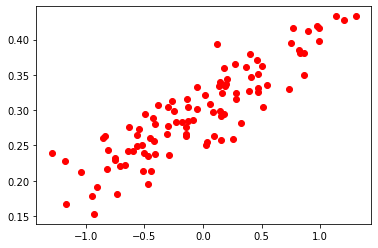

In [4]:
plt.scatter(data_np[:,0], data_np[:,1], c='red')
plt.show()

In [20]:
Data = tf.Variable(data_np, dtype=float)

### 参考使用tensorflow求导来对线性回归拟合

In [ ]:
import tensorflow as tf  # tf为2.0版本 python版本为3.6
import matplotlib.pyplot as plt 
import numpy as np
# 定义原数据
X_raw = np.array([2013,2014,2015,2016,2017],dtype=np.float32)
Y_raw = np.array([12000,14000,15000,16500,17500],dtype=np.float32)

# 数据归一化
x = (X_raw - X_raw.min())/(X_raw.max() - X_raw.min())
y = (Y_raw - Y_raw.min())/(Y_raw.max() - Y_raw.min())
# 定义张量
X = tf.constant(x)
y = tf.constant(y)
# 定义参数
a = tf.Variable(initial_value=0.)
b = tf.Variable(initial_value=0.)
variables = [a,b]

num_epoch = 10000 # 定义迭代次数
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3) # 定义优化器，用以后续更新参数
for e in range(num_epoch): # 迭代多次，更新参数a与b
    # 使用tf.GradientTape() 记录损失函数的梯度信息
    with tf.GradientTape() as tape:
        y_pred = a * X + b 
        loss = tf.reduce_sum(tf.square(y_pred - y)) # 通过预测值与实际值 求出误差
    # Tensorflow 自动计算损失函数关于自变量（模型参数）的梯度
    grads = tape.gradient(loss,variables) # 求损失关于参数a b的梯度
    # Tensorflow 自动根据梯度更新参数，即利用梯度信息修改a与b，使得损失减小
    optimizer.apply_gradients(grads_and_vars=zip(grads,variables)) 
print(a,b)

## 按照李宏毅课程中的步骤来完成。

### 定义超参数hyper parameters

In [ ]:
# 学习步长
learning_rate = 0.0001
# 循环次数
circle_count = 1000

### 首先定义函数

### 定义损失

### 定义优化

## 然后对一个五维的数据进行计算

------------------

## 没有使用正确的代码

In [2]:
R = np.array([[4,0,1,0,5],
     [1,2,1,3,5],
     [4,5,3,1,0],
     [2,3,0,2,5],
     [5,1,4,0,0],
     [0,3,2,4,1]])
# 为0的地方并不是评分为0，而是用户并没有对该物品进行评价。没有评分的地方并不用考虑它的误差。
R.shape

(6, 5)

In [3]:
"""_summary_
输入
R 是m*n的评分矩阵
K 隐性特征向量维度。注意这个特征维度是人为定义的。但是按道理这不应该有人为定义。
steps/max_iter 最大迭代步长
alpha 步长
lamda 正则化系数

输出
分解之后的P和Q
P 初始化用户特征矩阵m*k
Q 初始化物品特征矩阵k*n
"""

# 对超参数进行赋值
K=2
max_iter = 5000 #迭代次数多意味着步长比较小。
alpha = 0.0002
lamda = 0.004

def grad(R, K=2, max_iter= 5000, alpha=0.001, lamda= 0.002, cost_threshold = 0.0001):
    m = len(R)
    n = len(R[0])
    
    P = np.random.rand(m, K)
    Q = np.random.rand(K, n)
    
    for step in range(max_iter):
        # 对所有的用户u和物品i做遍历。对对应的Pu和Qi向量进行梯度下降。
        for u in range(m):
            for i in range(n):
                # 对于每一个大于0的评分，求出评分误差。
                if R[u][i] > 0:
                    eui = np.dot(P[u, :],Q[:, i]) - R[u,i]
                    
                    # 带入梯度下降的公式，按照梯度下降算法更新当前的Pu和Qi。也就是按照K个隐藏维度来更新。
                    for k in range(K):
                        # 注意这里和公式不同的地方在于求和公式。由于求和是对i在求和，而本计算是包含在
                        # for i in range(n):当中的，就相对于每个步骤都减去了一个对于i的元素，所以不
                        # 用再求和了。
                        P[u][k] = P[u][k] - alpha * (2 * eui * Q[k][i] - 2 * lamda * P[u][k])
                        # 同样的
                        Q[k][i] = Q[k][i] - alpha * (2 * eui * P[u][k] - 2 * lamda * Q[k][i])
                
        # u和i遍历完成。所有特征向量都更新完成。可以计算预测评分矩阵。
        # predictR = np.dot(P, Q)
        # 计算当前的损失函数。
        cost = 0
        
        for u in range(m):
            for i in range(n):
                # 在评分矩阵R中为0的不计算损失函数，原因依然是为0的评分可能是用户没有评分。
                if R[u][i] > 0:
                    cost += (np.dot(P[u, :],Q[:, i]) - R[u,i]) ** 2
                    for k in range(K):
                        cost += lamda * (P[u][k] ** 2 + Q[k][i] ** 2)
        # 当损失函数小于某一个特定阈值时退出。
        if cost < cost_threshold:
            break
    return P, Q, cost

In [4]:
P, Q, cost = grad(R, K, max_iter, alpha, lamda)
predictR = np.dot(P, Q)
print("origin R is {}, \n\n predict Matrix is {}, \n\n  User matrix is {}, \n\n Item matrix is {}, \n\n Cost is {}\n\n".format(R, predictR, P, Q, cost))

origin R is [[4 0 1 0 5]
 [1 2 1 3 5]
 [4 5 3 1 0]
 [2 3 0 2 5]
 [5 1 4 0 0]
 [0 3 2 4 1]], 

 predict Matrix is [[ 3.08530702  1.92869752  2.11718031  3.54010476  5.13398751]
 [ 2.09603817  0.87096131  1.44174417  2.88328844  4.719205  ]
 [ 3.86158274  5.07022909  2.62923045  1.53899963 -1.01951784]
 [ 2.84000453  1.96195705  1.94740031  3.05549172  4.20276956]
 [ 4.67550674  1.81305316  3.21702057  6.57283231 10.89051844]
 [ 3.33665781  3.41411086  2.27933898  2.38243145  1.82918127]], 

  User matrix is [[ 1.61932674  0.59191702]
 [ 1.43891851  0.13441167]
 [-0.02179166  2.35952158]
 [ 1.34666796  0.65856847]
 [ 3.30977281  0.2207581 ]
 [ 0.72685412  1.44957194]], 

 Item matrix is [[ 1.30267523  0.40421375  0.89710065  1.94118608  3.31718897]
 [ 1.64862666  2.15257094  1.12259188  0.67017878 -0.40145036]], 

 Cost is 14.632448538433511




In [5]:
# 通过上面的结果观察，评分矩阵和实际的评分直接误差有点大。
# 这个时候思考可能分解的维度可能太低了，测试提高分解维度来观察结果。
K= 5
P, Q, cost = grad(R, K, max_iter, alpha, lamda)
predictR = np.dot(P, Q)
print("origin R is {}, \n\n predict Matrix is {}, \n\n  User matrix is {}, \n\n Item matrix is {}, \n\n Cost is {}\n\n".format(R, predictR, P, Q, cost))

origin R is [[4 0 1 0 5]
 [1 2 1 3 5]
 [4 5 3 1 0]
 [2 3 0 2 5]
 [5 1 4 0 0]
 [0 3 2 4 1]], 

 predict Matrix is [[3.98129334 2.88772337 1.03185416 2.2871385  5.00714545]
 [1.00423263 2.00907678 0.98400247 3.00982762 5.00561081]
 [4.02301129 4.99966975 2.99214759 0.99586013 8.17229013]
 [1.98796753 3.02288686 2.15911716 2.00039133 5.00294678]
 [5.01446274 1.00394671 3.99722158 3.87058576 1.44459909]
 [2.49623367 2.98782827 2.00730408 4.0123347  1.0034288 ]], 

  User matrix is [[ 0.77263191  0.39894275  0.44141781  0.83615125  1.64913806]
 [ 1.87732493  0.30978616  0.10762536  0.35761834  0.20940714]
 [ 0.76522684  1.97498457 -0.14383774  1.6699223   0.87418461]
 [ 1.08084512  1.22845156  0.21445352  0.66658305  0.17889472]
 [ 0.10747017  0.5456395   2.46119379  0.78410461  0.32887995]
 [ 0.70083521  1.35408608  1.35217766 -0.8015405   0.66165732]], 

 Item matrix is [[-0.00741578  0.6596376   0.17590694  1.51469259  2.00592624]
 [ 0.54959653  1.66837407  0.97702877  0.18853392  1.1026

## 使用tensorflow来实现特征值分解

In [6]:

import tensorflow as tf
import numpy as np
R_square = np.array([[4,0,1,0,5],
     [1,2,1,3,5],
     [4,5,3,1,0],
     [2,3,0,2,5],
     [5,1,4,0,0]])

In [7]:
# help(tf.gradients)

重新用矩阵的思维来写特征值分解。感觉以前写的有点问题。


用tensor来实现。用tensorflow来实现完成。但是还不是用的矩阵思维。还是有问题。主要是对算法理解还有问题。

In [47]:


import tensorflow as tf 

K=2
max_iter = 5000 #迭代次数多意味着步长比较小。
alpha = 0.0002
lamda = 0.004

def GDM_Tensor(R, K=2, max_iter= 5000, alpha=0.001, lamda= 0.002, cost_threshold = 0.0001):
    m = len(R)
    n = len(R[0])

    R_tf = tf.convert_to_tensor(R, dtype=float)
    P = tf.Variable(np.random.rand(m, K), dtype=float)
    Q = tf.Variable(np.random.rand(K, n), dtype=float)
    # print("Display P.shape={} and  Q.shape={}".format(P.shape, Q.shape))

    for step in range(max_iter):
        if step%100 == 0:
            print("Progress is {}".format(step/100 + 1))
        # 按逻辑对于用户必须逐行更新，对于item必须逐列更新。
        for u in range(m):
            for i in range(n):
                if R[u][i] > 0:
                    # print("Display P[u, :].shape={} and  Q[:, i].shape={}".format(P[u, :].shape, Q[:, i].shape))
                    # eui = tf.matmul(P[u, :], Q[:, i]) - R[u,i]
                    eui = (tf.matmul(tf.reshape(P[u, :], [1,K]), tf.reshape(Q[:, i], [K,1])) - R[u,i])[0,0]
                    # print(eui)
                    # print(type(eui))
                    for k in range(K):
                        # 注意这里和公式不同的地方在于求和公式。由于求和是对i在求和，而本计算是包含在
                        # for i in range(n):当中的，就相对于每个步骤都减去了一个对于i的元素，所以不
                        # 用再求和了。
                        P[u, k].assign(P[u, k] - alpha * (2 * eui * Q[k, i] - 2 * lamda * P[u, k]))
                        Q[k, i].assign(Q[k, i] - alpha * (2 * eui * P[u, k] - 2 * lamda * Q[k, i]))
                        break
                    
        # print("Cycle end.")
        # 这个是收敛条件之一。
        cost = tf.Variable(0.0)
        Eui_matrix = tf.matmul(P, Q) - R_tf
        cost = tf.reduce_sum(tf.reduce_sum(tf.square(Eui_matrix))) + lamda * (tf.reduce_sum(tf.reduce_sum(tf.square(P), 0)) + tf.reduce_sum(tf.reduce_sum(tf.square(Q), 0)))
        
        if cost <= cost_threshold:
            break
    
    return P, Q, cost

P, Q, cost = GDM_Tensor(R_square, K=2, max_iter=1000)

Progress is 0.0
Progress is 1.0
Progress is 2.0
Progress is 3.0
Progress is 4.0
Progress is 5.0
Progress is 6.0
Progress is 7.0
Progress is 8.0
Progress is 9.0


In [48]:
print(P)
print(Q)
print(cost)

<tf.Variable 'Variable:0' shape=(5, 2) dtype=float32, numpy=
array([[1.5650222 , 0.4134315 ],
       [1.3195595 , 0.64713115],
       [2.619709  , 0.37340465],
       [1.4728941 , 0.84225214],
       [2.181799  , 0.8092877 ]], dtype=float32)>
<tf.Variable 'Variable:0' shape=(2, 5) dtype=float32, numpy=
array([[1.5793083 , 1.3907872 , 1.1425058 , 0.84974104, 3.2946165 ],
       [0.6499688 , 0.14561683, 0.34822193, 0.11311472, 0.2997057 ]],
      dtype=float32)>
tf.Tensor(167.67068, shape=(), dtype=float32)


In [ ]:
# # 使用tensorflow来实现这个函数.

# import tensorflow as tf

# def ModifyTensor(input_tensor, position=None, value=None):
#     input_tensor = input_tensor.numpy()
#     input_tensor[tuple(position)] = value
#     return input_tensor

# K=2
# max_iter = 5000 #迭代次数多意味着步长比较小。
# alpha = 0.0002
# lamda = 0.004

# # tf.debugging.set_log_device_placement(True)
# def grad_tf(R, K=2, max_iter= 5000, alpha=0.001, lamda= 0.002, cost_threshold = 0.0001):
#     R_tf = tf.convert_to_tensor(R, dtype=float)
#     m = len(R)
#     n = len(R[0])
    
#     # P = np.random.rand(m, K)
#     # Q = np.random.rand(K, n)
#     P = tf.Variable(tf.zeros([m, K], dtype=float))
#     Q = tf.Variable(tf.zeros([K, n], dtype=float))
    
#     for step in range(max_iter):
#         # 对所有的用户u和物品i做遍历。对对应的Pu和Qi向量进行梯度下降。
#         for u in range(m):
#             for i in range(n):
#                 # 对于每一个大于0的评分，求出评分误差。
#                 if R_tf[u][i] > 0:
#                     eui = tf.matmul(tf.reshape(P[u, :], [1, -1]),tf.reshape(Q[:, i], [-1, 1])) - R_tf[u,i]
                    
#                     # 带入梯度下降的公式，按照梯度下降算法更新当前的Pu和Qi。也就是按照K个隐藏维度来更新。
#                     for k in range(K):
#                         # 注意这里和公式不同的地方在于求和公式。由于求和是对i在求和，而本计算是包含在
#                         # for i in range(n):当中的，就相对于每个步骤都减去了一个对于i的元素，所以不
#                         # 用再求和了。
#                         P = tf.py_function(ModifyTensor, 
#                                            inp=[P, [u, k], P[u][k] - alpha * (2 * eui * Q[k][i] - 2 * lamda * P[u][k])], 
#                                            Tout=P.dtype)
#                         # 同样的
#                         Q = tf.py_function(ModifyTensor, 
#                                            inp=[Q, [k, i], Q[k][i] - alpha * (2 * eui * P[u][k] - 2 * lamda * Q[k][i])], 
#                                            Tout=Q.dtype)
                
#         # u和i遍历完成。所有特征向量都更新完成。可以计算预测评分矩阵。
#         # predictR = np.dot(P, Q)
#         # 计算当前的损失函数。
#         cost = 0
        
#         for u in range(m):
#             for i in range(n):
#                 # 在评分矩阵R_tf中为0的不计算损失函数，原因依然是为0的评分可能是用户没有评分。
#                 if R_tf[u][i] > 0:
#                     cost += (tf.matmul(tf.reshape(P[u, :], [1, -1]),tf.reshape(Q[:, i], [-1, 1])) - R_tf[u,i]) ** 2
#                     for k in range(K):
#                         cost += lamda * (tf.square(P[u][k]) + tf.square(Q[k][i]))
#         # 当损失函数小于某一个特定阈值时退出。
#         if cost < cost_threshold:
#             break
#     return P, Q, cost

In [ ]:
# P, Q, cost = grad_tf(R, K=3)

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [ ]:

# R_tf = tf.convert_to_tensor(R_square, dtype=float)
# # tensorflow进行eig必须是方阵。
# # 
# M, N = tf.eig(R_tf)


Executing op Eig in device /job:localhost/replica:0/task:0/device:CPU:0


In [ ]:
# print(M)

tf.Tensor(
[ 0.5489885-1.8442735e-08j -1.7649044-1.9651887e+00j
 -1.7649044+1.9651892e+00j  2.9616973-3.0399860e-08j
 11.019123 +6.4537744e-09j], shape=(5,), dtype=complex64)


In [ ]:
# print(N)

tf.Tensor(
[[-0.50880915+0.00434304j  0.28622308-0.30314255j -0.38530356+0.15924889j
  -0.56747574+0.20958522j  0.35919613-0.00087918j]
 [ 0.20886296-0.00178275j  0.05577823-0.29754078j -0.29786214-0.05403553j
   0.42365906-0.15646952j  0.4714589 -0.00115396j]
 [ 0.61511016-0.0052503j  -0.1284342 +0.6106717j   0.61630976+0.09786545j
   0.6015964 -0.2221869j   0.530147  -0.0012976j ]
 [-0.5167199 +0.00441057j  0.38827828+0.04287843j -0.09845588+0.37802777j
   0.12856518-0.04748289j  0.4572356 -0.00111915j]
 [ 0.22815934-0.00194746j -0.42346954+0.11488671j  0.25839487-0.35462296j
  -0.00247677+0.00091478j  0.39821923-0.00097469j]], shape=(5, 5), dtype=complex64)


In [ ]:
# x = tf.constant([[1,2], [3,4]])
# y = tf.add(x, 1)
# print(y)

Executing op Add in device /job:localhost/replica:0/task:0/device:CPU:0
tf.Tensor(
[[2 3]
 [4 5]], shape=(2, 2), dtype=int32)
